# TODO scrape any car data from ss.com
* clean up prices as numerics
* group by make and model
* plot the data - pricing for sure
* if you do more advanced analysis that also could be used for the final project

* for those who want scraping part of final project
* scrape data from somewhere else - maybe Lithuanian ss.com or wikipedia?

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Get URL and scrape the data, save to CSV file 

In [3]:
url = "https://www.ss.com/en/transport/cars/audi/"
url


'https://www.ss.com/en/transport/cars/audi/'

In [4]:
req = requests.get(url)  #extracting the html
req.status_code

200

In [5]:
soup = BeautifulSoup(req.text, 'lxml') 
soup.title

<title>SS.COM Cars - Audi, Prices - Advertisements</title>

In [6]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"}) #this will work as long as html has a table row with id head_line
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]]  # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [7]:
column_names = getColList(soup)
column_names  # to be used later when creating our table

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [8]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [9]:
# from row get dictionary with values 
def getRow(row, colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [10]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [11]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows)
    

In [12]:
audi_cars = "https://www.ss.com/en/transport/cars/audi/"
idf = getDFfromURL(audi_cars)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,Pārdošanā ļoti kopts Audi A4. S-line. 2.7 dīze...,https://ss.com/msg/en/transport/cars/audi/a4/a...,A4,2007,2.7D,-,"4,650 €"
1,Īpašniece bez steigas pārdod Audi A3 ar ļoti k...,https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2008,1.8,180 thd.,"7,200 €"
2,"Audi-A4, 2.7 Tdi, 190zs. Automāts. \r\n\r\n-Bi...",https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2008,2.7D,333 thd.,"6,650 €"
3,Audi A8 3.0Tdi Quattro Facelift S-Line Auto pe...,https://ss.com/msg/en/transport/cars/audi/a8/d...,A8,2007,3.0D,-,"8,950 €"
4,"Sveiki. Pārdodu šo auto jo iegādājos jaunu, di...",https://ss.com/msg/en/transport/cars/audi/a6/f...,A6,2005,3.0D,346 thd.,"4,800 €"


# Read CSV file, clean up prices, sort data by model and year

In [13]:
idf.to_csv("audi_sell_list.csv")

In [14]:
audi_df = pd.read_csv("audi_sell_list.csv")
audi_df.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Pārdošanā ļoti kopts Audi A4. S-line. 2.7 dīze...,https://ss.com/msg/en/transport/cars/audi/a4/a...,A4,2007,2.7D,-,"4,650 €"
1,1,Īpašniece bez steigas pārdod Audi A3 ar ļoti k...,https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2008,1.8,180 thd.,"7,200 €"
2,2,"Audi-A4, 2.7 Tdi, 190zs. Automāts. \r\n\r\n-Bi...",https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2008,2.7D,333 thd.,"6,650 €"
3,3,Audi A8 3.0Tdi Quattro Facelift S-Line Auto pe...,https://ss.com/msg/en/transport/cars/audi/a8/d...,A8,2007,3.0D,-,"8,950 €"
4,4,"Sveiki. Pārdodu šo auto jo iegādājos jaunu, di...",https://ss.com/msg/en/transport/cars/audi/a6/f...,A6,2005,3.0D,346 thd.,"4,800 €"


In [15]:
audi_df['Price'] = audi_df['Price'].str.replace(unicodedata.lookup('EURO SIGN'), '')
audi_df['Price'] = audi_df['Price'].str.replace(",", '')

audi_df.head()



,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Pārdošanā ļoti kopts Audi A4. S-line. 2.7 dīze...,https://ss.com/msg/en/transport/cars/audi/a4/a...,A4,2007,2.7D,-,4650
1,1,Īpašniece bez steigas pārdod Audi A3 ar ļoti k...,https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2008,1.8,180 thd.,7200
2,2,"Audi-A4, 2.7 Tdi, 190zs. Automāts. \r\n\r\n-Bi...",https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2008,2.7D,333 thd.,6650
3,3,Audi A8 3.0Tdi Quattro Facelift S-Line Auto pe...,https://ss.com/msg/en/transport/cars/audi/a8/d...,A8,2007,3.0D,-,8950
4,4,"Sveiki. Pārdodu šo auto jo iegādājos jaunu, di...",https://ss.com/msg/en/transport/cars/audi/a6/f...,A6,2005,3.0D,346 thd.,4800


In [16]:
audi_df['Price'].describe()  

count       30
unique      24
top       buy 
freq         7
Name: Price, dtype: object

In [17]:
audi_df['Price'] = pd.to_numeric(audi_df['Price'], errors='coerce')  #convert dtyper: object to dtype:float64
audi_df['Price'].describe()

count       22.000000
mean      7518.363636
std       8740.949897
min        450.000000
25%       1662.500000
50%       4825.000000
75%       8512.500000
max      35995.000000
Name: Price, dtype: float64

# sorting price vs year


In [18]:
# audi_df.groupby(['Year']).describe()['Price']

In [19]:
audi_sorted_by_year = audi_df.sort_values(["Year"],ascending=True)
audi_sorted_by_year.tail(15)

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
11,11,"Продаю или Меняю, расход 6-7л. /100км. , в Лат...",https://ss.com/msg/en/transport/cars/volkswage...,Golf 5,2004,1.4,-,NaN
21,21,Audi A4 3.0 dīzelis 150 kW quattro. Labā tehni...,https://ss.com/msg/en/transport/cars/audi/a4/c...,A4,2005,3.0D,302 thd.,4850.0
4,4,"Sveiki. Pārdodu šo auto jo iegādājos jaunu, di...",https://ss.com/msg/en/transport/cars/audi/a6/f...,A6,2005,3.0D,346 thd.,4800.0
9,9,Авто в хорошем состоянии только пройден ТО дор...,https://ss.com/msg/en/transport/cars/audi/a4/g...,A4,2006,2.7D,-,3100.0
0,0,Pārdošanā ļoti kopts Audi A4. S-line. 2.7 dīze...,https://ss.com/msg/en/transport/cars/audi/a4/a...,A4,2007,2.7D,-,4650.0
18,18,Auto labā stāvoklī. Ir nenozīmīgi vizuālie def...,https://ss.com/msg/en/transport/cars/audi/q7/b...,Q7,2007,3.0D,410 thd.,6250.0
3,3,Audi A8 3.0Tdi Quattro Facelift S-Line Auto pe...,https://ss.com/msg/en/transport/cars/audi/a8/d...,A8,2007,3.0D,-,8950.0
15,15,Audi A4 2.7l dīzelis. 140Kw\r\nTehniskā apskat...,https://ss.com/msg/en/transport/cars/audi/a4/h...,A4,2008,2.7D,-,7190.0
2,2,"Audi-A4, 2.7 Tdi, 190zs. Automāts. \r\n\r\n-Bi...",https://ss.com/msg/en/transport/cars/audi/a4/b...,A4,2008,2.7D,333 thd.,6650.0
1,1,Īpašniece bez steigas pārdod Audi A3 ar ļoti k...,https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2008,1.8,180 thd.,7200.0


Text(0.5, 1.0, 'Audi price by year')

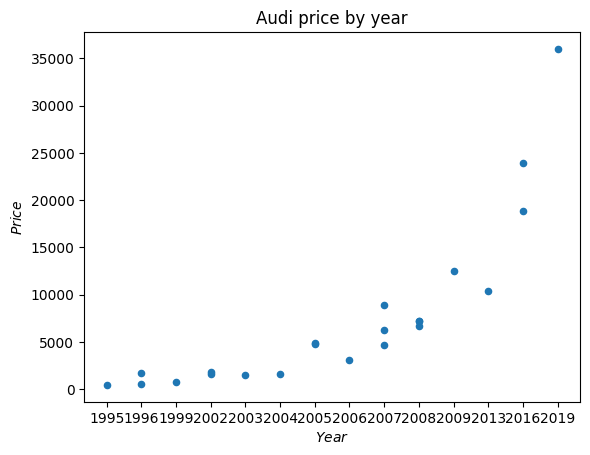

In [20]:
audi_price_plot = pd.DataFrame(audi_sorted_by_year,columns=['Year','Price'])
audi_price_plot.plot(x ='Year', y='Price', kind = 'scatter')
plt.xlabel('$Year$')
plt.ylabel('$Price$')
plt.title('Audi price by year')

# plot by model

In [32]:
audi_model = audi_df.groupby(['Model']).count()
audi_model

,Unnamed: 0,description,url,Year,Volume,Run,Price
Model,,,,,,,
A3,1,1,1,1,1,1,1
A4,14,14,14,14,14,14,13
A6,4,4,4,4,4,4,3
A7,1,1,1,1,1,1,0
A8,1,1,1,1,1,1,1
Allroad,1,1,1,1,1,1,1
Golf 5,1,1,1,1,1,1,0
Q5,2,2,2,2,2,2,2
Q7,1,1,1,1,1,1,1


In [28]:
audi_model = audi_df.groupby(['Model']).count()
audi = audi_model.drop(columns=["url"])
audi

,Unnamed: 0,description,Year,Volume,Run,Price
Model,,,,,,
A3,1,1,1,1,1,1
A4,14,14,14,14,14,13
A6,4,4,4,4,4,3
A7,1,1,1,1,1,0
A8,1,1,1,1,1,1
Allroad,1,1,1,1,1,1
Golf 5,1,1,1,1,1,0
Q5,2,2,2,2,2,2
Q7,1,1,1,1,1,1


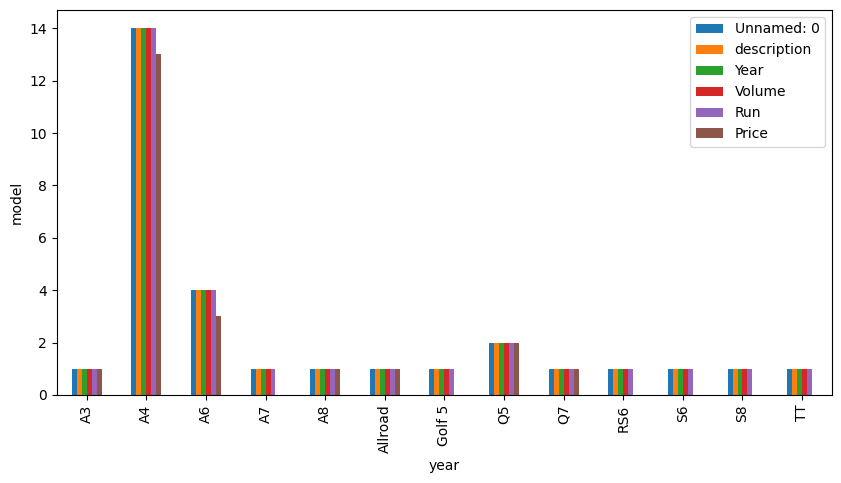

In [33]:
ax = audi.plot(kind='bar', figsize=(10,5))
ax.set(xlabel="year", ylabel="model")
ax.yaxis.set_major_formatter(ticker.EngFormatter())